In [54]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
jan = pd.read_csv('data/data_by_month/jan_2023.csv')
feb = pd.read_csv('data/data_by_month/feb_2023.csv')
mar = pd.read_csv('data/data_by_month/mar_2023.csv')
apr = pd.read_csv('data/data_by_month/apr_2023.csv')
may = pd.read_csv('data/data_by_month/may_2023.csv')
jun = pd.read_csv('data/data_by_month/jun_2023.csv')
jul = pd.read_csv('data/data_by_month/jul_2023.csv')
aug = pd.read_csv('data/data_by_month/aug_2023.csv')
sep = pd.read_csv('data/data_by_month/sep_2023.csv')
oct = pd.read_csv('data/data_by_month/oct_2023.csv')
nov = pd.read_csv('data/data_by_month/nov_2023.csv')
dec = pd.read_csv('data/data_by_month/dec_2023.csv')
df = pd.concat([jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec])
ids = pd.read_csv('data/airline_id.csv')

In [56]:
# data cleaning
df.fillna(0, inplace=True)

# rename airlines
airline_names = pd.DataFrame(df['OP_CARRIER_AIRLINE_ID'].unique(), columns=['Code']).merge(ids, on='Code', how='left')
airline_names['Description'] = airline_names['Description'].apply(lambda x: x.split(':')[0])
airline_names['Description'] = airline_names['Description'].apply(lambda x: x.split('LLC')[0])
airline_names['Description'] = airline_names['Description'].apply(lambda x: x.split('Inc.')[0])
airline_names['Description'] = airline_names['Description'].apply(lambda x: x.split('Corp')[0])
airline_names['Description'] = airline_names['Description'].apply(lambda x: x.split('Co.')[0])

df


,MONTH,OP_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_STATE_ABR,DEST_STATE_NM,DEP_DELAY,TAXI_OUT,ARR_DELAY,CANCELLED,DIVERTED,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,19393,10140,NM,New Mexico,10423,TX,Texas,0.0,0.0,0.0,1.0,0.0,0.0,619.0,0.0,0.0,0.0,0.0,0.0
1,1,19393,10140,NM,New Mexico,10423,TX,Texas,0.0,0.0,0.0,1.0,0.0,0.0,619.0,0.0,0.0,0.0,0.0,0.0
2,1,19393,10140,NM,New Mexico,10423,TX,Texas,-10.0,9.0,-14.0,0.0,0.0,77.0,619.0,0.0,0.0,0.0,0.0,0.0
3,1,19393,10140,NM,New Mexico,10423,TX,Texas,-9.0,11.0,-2.0,0.0,0.0,76.0,619.0,0.0,0.0,0.0,0.0,0.0
4,1,19393,10140,NM,New Mexico,10423,TX,Texas,-8.0,11.0,-20.0,0.0,0.0,80.0,619.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606213,12,20500,15380,MI,Michigan,13930,IL,Illinois,16.0,48.0,38.0,0.0,0.0,49.0,224.0,0.0,0.0,22.0,0.0,16.0
606214,12,20500,15380,MI,Michigan,13930,IL,Illinois,47.0,17.0,41.0,0.0,0.0,44.0,224.0,0.0,0.0,0.0,0.0,41.0
606215,12,20500,15380,MI,Michigan,13930,IL,Illinois,72.0,35.0,80.0,0.0,0.0,57.0,224.0,0.0,0.0,8.0,0.0,72.0
606216,12,20500,15380,MI,Michigan,13930,IL,Illinois,88.0,45.0,102.0,0.0,0.0,43.0,224.0,0.0,0.0,14.0,0.0,88.0


In [57]:
# create an array of the delay types
delay_fields = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'CANCELLED']

# prep the df to support a total flight field per airline
df['TOTAL_FLIGHTS'] = 1

# group by airline and sum the desired fields, merge with airline names
grouped_df = df.groupby('OP_CARRIER_AIRLINE_ID').agg({delay_fields[0]: 'sum', delay_fields[1]: 'sum', delay_fields[2]: 'sum', delay_fields[3]: 'sum', delay_fields[4]: 'sum', 'CANCELLED': 'sum', 'DIVERTED': 'sum', 'TOTAL_FLIGHTS': 'sum'}).reset_index()
grouped_with_airline = pd.merge(grouped_df, airline_names, left_on='OP_CARRIER_AIRLINE_ID', right_on='Code')


average_delays = grouped_with_airline
for delay in delay_fields:
    average_delays[delay] = grouped_with_airline[delay] / grouped_with_airline['TOTAL_FLIGHTS']

Look at averages

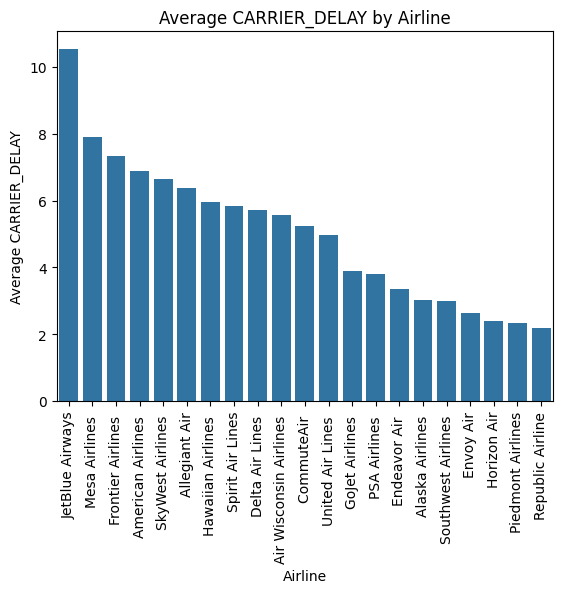

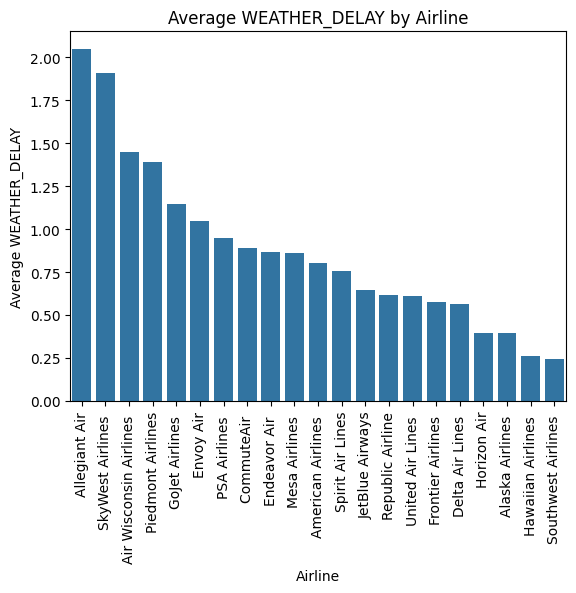

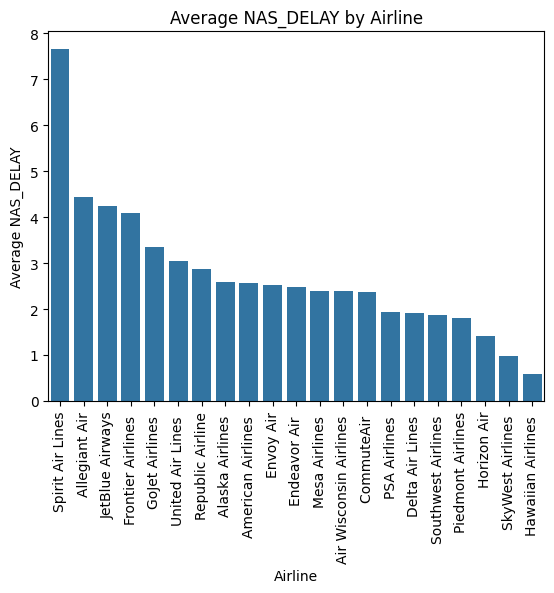

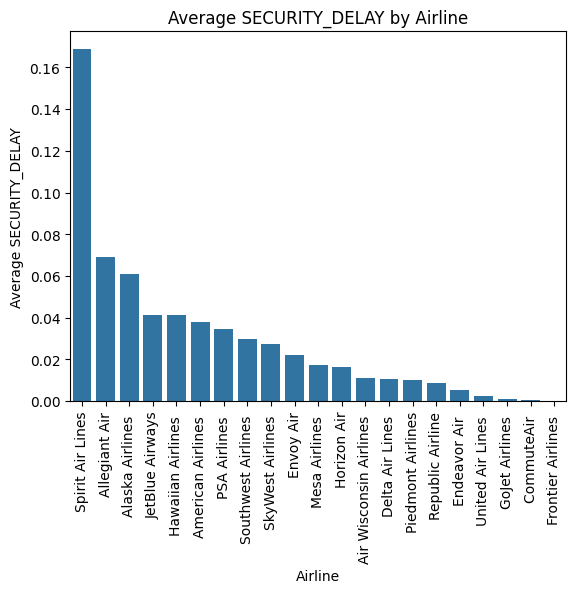

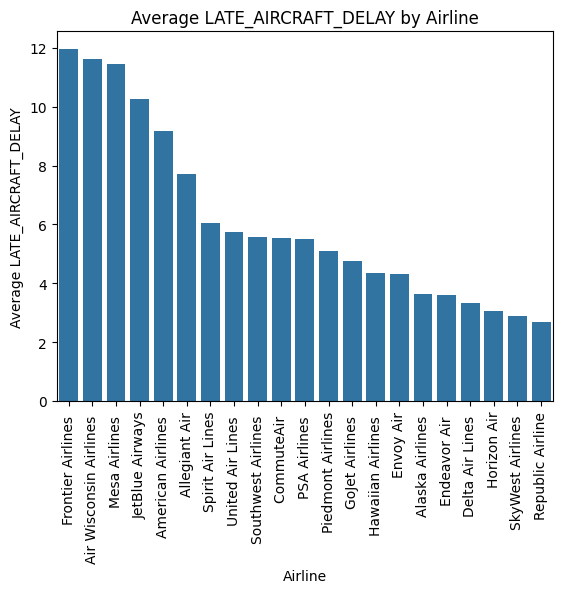

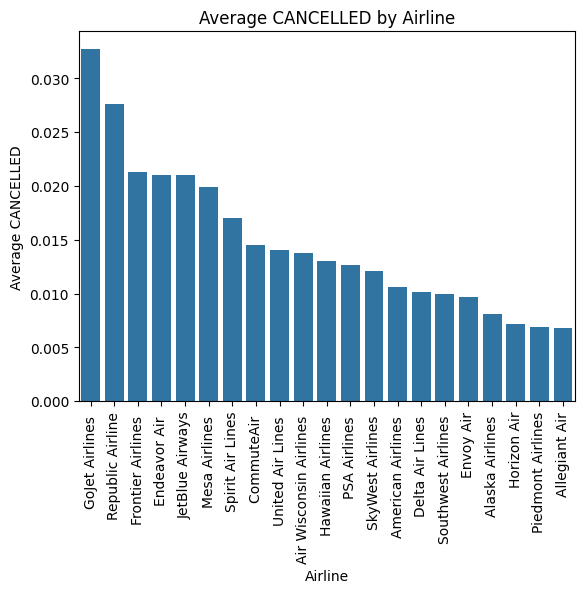

In [58]:

for delay in delay_fields:
    average_delays_sorted = average_delays.sort_values(f'{delay}', ascending=False)
    plt.figure()
    plt.title(f'Average {delay} by Airline')
    plt.xlabel('Airline')
    plt.ylabel(f'Average {delay}')
    plt.xticks(rotation=90)
    sns.barplot(x='Description', y=f'{delay}', data=average_delays_sorted)





Create a ranking for best and worst airlines

<Axes: title={'center': 'Airline Ranking'}, xlabel='Airline', ylabel='Score'>

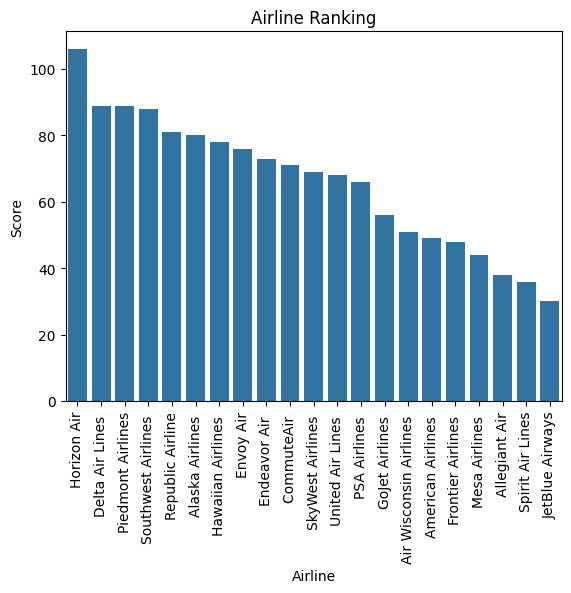

In [60]:
# create weighted scores for each airline
ranks = pd.DataFrame(zip(airline_names['Description'], np.zeros(len(airline_names['Description']))), columns=['Airline', 'Score'])
for feature in delay_fields:
    temp = average_delays.sort_values(feature, ascending=False)
    position = 1
    for row in temp.iterrows():
        ranks.loc[ranks['Airline'] == row[1]['Description'], 'Score'] += position
        position += 1
ranks
sorted_ranks = ranks.sort_values('Score', ascending=False)
plt.figure()
plt.title('Airline Ranking')
plt.xlabel('Airline')
plt.ylabel('Score')
plt.xticks(rotation=90)
sns.barplot(x='Airline', y='Score', data=sorted_ranks)

        

It makes sense that JetBlue is last, multiple sites rank it as the worst performer in regards to delays and other factors